In [1]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing, metrics, naive_bayes, pipeline,feature_extraction
import operator
import matplotlib.pyplot as plt
import urllib.request
from inscriptis import get_text
from sklearn.svm import SVC

Using TensorFlow backend.


In [3]:
def getdataframe():
    title=[]
    desc=[]
    category=[]
    COUNT=0
    with open('Downloads/dmoz.csv', 'r',encoding="utf8") as f:
        reader=csv.reader(f)
        for row in reader:
            if COUNT!=0:
                category.append(row[1])
                title.append(row[2])
                desc.append(row[3])
            else:
                COUNT=COUNT+1
    df=pd.DataFrame(columns=['category','title','desc'])
    df.category = category
    df.title = title
    df.desc=desc
    return df

df=getdataframe()

In [5]:
df.shape



(1195851, 3)

In [6]:
df.head()


,category,title,desc
0,Arts,About.com: Animation Guide,Keep up with developments in online animation ...
1,Arts,Toonhound,"British cartoon, animation and comic strip cre..."
2,Arts,Enculturation: From Mouse to Mouse: Overcoming...,Essay by Patricia Pisters on the animated imag...
3,Arts,Digital Media FX: The History of Animation,Michael Crandol takes an exhaustive look at th...
4,Arts,Spark Online: Only Genius Is Genius,Chris Romano feels that the proliferation of F...


In [7]:
df.tail()


,category,title,desc
1195846,Sports,MaxPreps.com,High school sports and athletes as well as spo...
1195847,Sports,My Score,"High school sports scores, standings, and sche..."
1195848,Sports,Sports Illustrated: High School Sports,"News, analysis, commentary, feature articles, ..."
1195849,Sports,Sports Illustrated: High School Sports,Headline news and feature stories.
1195850,Sports,USA Today: Preps,Features high school news and the Super 25 Ind...


Text(0.5, 1.0, 'Category Counts')

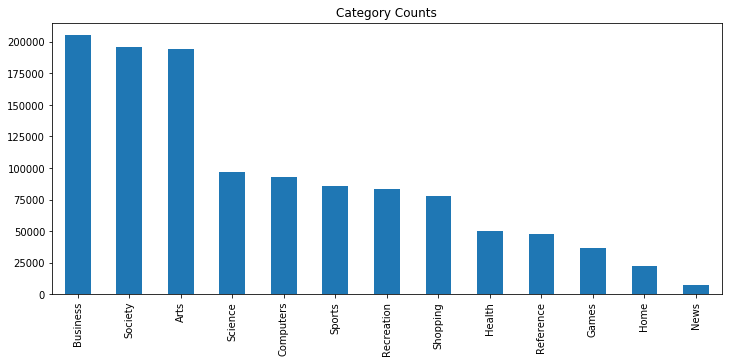

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
df.category.value_counts().plot(kind='bar')
plt.title('Category Counts')

In [14]:
lens = [len(x) for x in df.desc]
print(max(lens), min(lens), np.mean(lens))

984 3 106.54395572692584


In [15]:
df.desc=df.title+' '+df.desc
df=df.drop(['title'],axis=1)
df.desc= df.desc.str.lower()


In [20]:
pipe = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                         ('tfidf', feature_extraction.text.TfidfTransformer()),
                         ('clf',naive_bayes.ComplementNB())])
le = preprocessing.LabelEncoder()
le.fit(df.category)
y_data = le.transform(df.category)
X_data = df.desc.values
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, \
        test_size=0.2, random_state=1000)

In [21]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...lse, use_idf=True)), ('clf', ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False))])

In [22]:
print (metrics.classification_report(pipe.predict(X_test), y_test, target_names=le.classes_))

              precision    recall  f1-score   support

        Arts       0.89      0.77      0.83     44521
    Business       0.84      0.74      0.79     47390
   Computers       0.79      0.79      0.79     18528
       Games       0.71      0.89      0.79      5932
      Health       0.82      0.79      0.80     10449
        Home       0.58      0.75      0.65      3420
        News       0.27      0.73      0.39       543
  Recreation       0.72      0.80      0.76     15024
   Reference       0.46      0.70      0.56      6271
     Science       0.68      0.78      0.72     16471
    Shopping       0.52      0.73      0.61     11195
     Society       0.82      0.80      0.81     40196
      Sports       0.91      0.81      0.86     19231

   micro avg       0.78      0.78      0.78    239171
   macro avg       0.69      0.77      0.72    239171
weighted avg       0.80      0.78      0.78    239171



In [23]:
n_iter_search = 10
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}
gs_clf = RandomizedSearchCV(pipe, parameters, n_iter = n_iter_search)
gs_clf = gs_clf.fit(X_train, y_train)

c:\users\bharg\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\bharg\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [24]:
print (metrics.classification_report(gs_clf.predict(X_test), y_test, target_names=le.classes_))

              precision    recall  f1-score   support

        Arts       0.90      0.83      0.86     42318
    Business       0.88      0.79      0.83     45775
   Computers       0.84      0.81      0.82     19105
       Games       0.80      0.91      0.85      6456
      Health       0.86      0.82      0.84     10512
        Home       0.67      0.82      0.73      3563
        News       0.48      0.75      0.59       945
  Recreation       0.77      0.85      0.81     15310
   Reference       0.57      0.71      0.64      7641
     Science       0.73      0.80      0.76     17335
    Shopping       0.64      0.77      0.70     12948
     Society       0.85      0.85      0.85     39132
      Sports       0.93      0.88      0.90     18131

   micro avg       0.82      0.82      0.82    239171
   macro avg       0.76      0.81      0.78    239171
weighted avg       0.83      0.82      0.82    239171



In [29]:
site=input("Enter the site you want to classify : ") 
url = site
html = urllib.request.urlopen(url).read().decode('utf-8')
text = get_text(html)
print("Before HyperTuning ",le.inverse_transform(pipe.predict([text])))
print("After HyperTuning ",le.inverse_transform(gs_clf.predict([text])))


Enter the site you want to classify : https://www.christies.com/
Before HyperTuning  ['Arts']
After HyperTuning  ['Arts']


['Arts']
